# Prepare Environment

In [ ]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
from collections import Counter
import os

from imblearn.over_sampling import RandomOverSampler
from collections import defaultdict
from transformers import AutoImageProcessor, TFViTModel
from tensorflow.keras import layers

import datetime
import time




Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]

NumPy 1.26.4

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last


In [ ]:
import keras
keras.__version__

'3.4.1'

In [ ]:
# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
# Seed 1
#np.random.seed(1234)
#tf.random.set_seed(5678)

# Seed 2
#np.random.seed(123)
#tf.random.set_seed(5667)

# Seed 3
#np.random.seed(99)
#tf.random.set_seed(100)

# Import Data and Pre-processing

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


Firstly, import the image. The image will originally be 256 pixels in size.

In [ ]:
batch_size = 16
CROP_LENGTH = 224


In [ ]:
# Path ของโฟลเดอร์ชุดข้อมูลใน Google Drive
dataset_dir = '/content/drive/MyDrive/DADS_Deep Learning/Final_Project/Picture'  # แทนที่ด้วย path ของชุดข้อมูลใน Google Drive


def load_dataset(directory):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        shuffle=True
    )

    class_names = dataset.class_names

    images = []
    labels = []
    for batch, label in dataset:
        images.append(batch.numpy())
        labels.append(label.numpy())

    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

    return images, labels, class_names

def count_images_per_class(labels, class_names):
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = {class_names[i]: counts[i] for i in unique}
    return class_counts

# Load datasets
x_train, y_train, train_class_names = load_dataset(os.path.join(dataset_dir, 'Train'))
x_val, y_val, val_class_names = load_dataset(os.path.join(dataset_dir, 'Valid'))
x_test, y_test, test_class_names = load_dataset(os.path.join(dataset_dir, 'Test'))

# Verify dataset shapes
print(f'Training data shape: {x_train.shape}, {y_train.shape}')
print(f'Validation data shape: {x_val.shape}, {y_val.shape}')
print(f'Test data shape: {x_test.shape}, {y_test.shape}')

# Count images per class
train_class_counts = count_images_per_class(y_train, train_class_names)
val_class_counts = count_images_per_class(y_val, val_class_names)
test_class_counts = count_images_per_class(y_test, test_class_names)

# Display class counts
print('Training data class counts:', train_class_counts)
print('Validation data class counts:', val_class_counts)
print('Test data class counts:', test_class_counts)

Found 828 files belonging to 2 classes.
Found 177 files belonging to 2 classes.
Found 177 files belonging to 2 classes.
Training data shape: (828, 256, 256, 3), (828,)
Validation data shape: (177, 256, 256, 3), (177,)
Test data shape: (177, 256, 256, 3), (177,)
Training data class counts: {'damage': 578, 'good': 250}
Validation data class counts: {'damage': 123, 'good': 54}
Test data class counts: {'damage': 123, 'good': 54}


Plot images after loading dataset

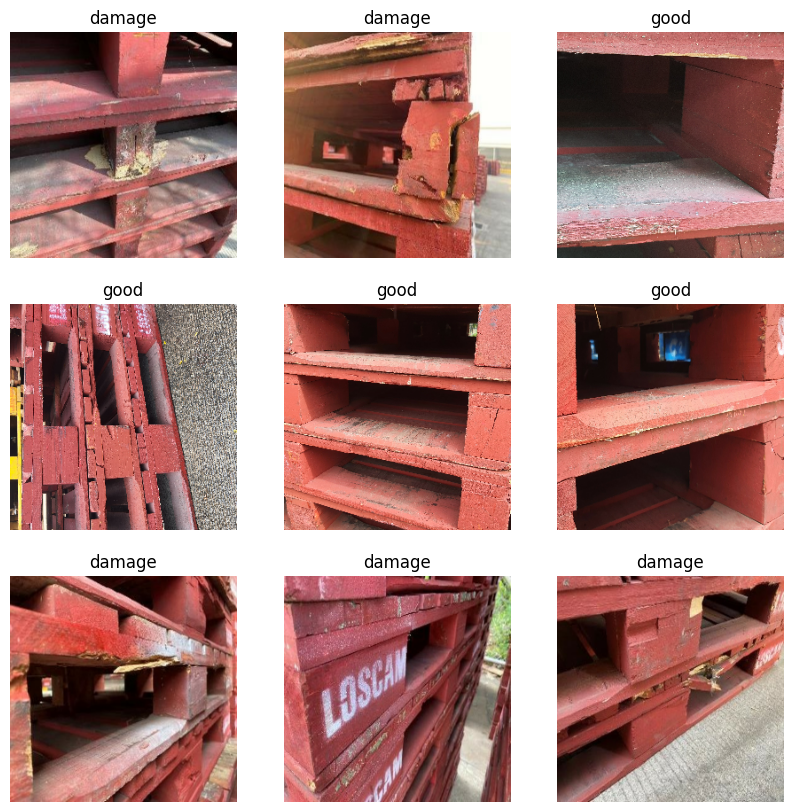

In [ ]:
def plot_random_images(images, labels, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(images), num_images, replace=False)
    for i, idx in enumerate(indices):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx].astype("uint8"))
        plt.title(class_names[labels[idx]])
        plt.axis("off")
    plt.show()


# Plot a sample of images
plot_random_images(x_train, y_train, train_class_names, num_images=9)

## Ramdom Crop from 256 to 224

In [ ]:
CROP_LENGTH = 224
# Apply Random Cropping

# Function to apply random cropping
def random_crop(img, random_crop_size):
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

# Apply random cropping to the entire dataset
def apply_random_cropping(images, labels, crop_length):
    cropped_images = np.zeros((images.shape[0], crop_length, crop_length, 3))
    for i in range(images.shape[0]):
        cropped_images[i] = random_crop(images[i], (crop_length, crop_length))
    return cropped_images, labels


# Apply random cropping
x_train_cropped, y_train_cropped = apply_random_cropping(x_train, y_train, CROP_LENGTH)
x_val_cropped, y_val_cropped = apply_random_cropping(x_val, y_val, CROP_LENGTH)
x_test_cropped, y_test_cropped = apply_random_cropping(x_test, y_test, CROP_LENGTH)

# Print shapes of cropped datasets
print(f'Training data shape after cropping: {x_train_cropped.shape}')
print(f'Training labels shape: {y_train_cropped.shape}')
print(f'Validation data shape after cropping: {x_val_cropped.shape}')
print(f'Validation labels shape: {y_val_cropped.shape}')
print(f'Test data shape after cropping: {x_test_cropped.shape}')
print(f'Test labels shape: {y_test_cropped.shape}')

Training data shape after cropping: (828, 224, 224, 3)
Training labels shape: (828,)
Validation data shape after cropping: (177, 224, 224, 3)
Validation labels shape: (177,)
Test data shape after cropping: (177, 224, 224, 3)
Test labels shape: (177,)


## Rescale and Augmentation

In [ ]:
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.5, 0.2),
  layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='constant', name='rand_trans')
])

In [ ]:
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # rescale all datasets.
  ds = ds.map(lambda x, y: (rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Create a tf.data.Dataset from the NumPy arrays
train_ds = tf.data.Dataset.from_tensor_slices((x_train_cropped, y_train_cropped))
val_ds = tf.data.Dataset.from_tensor_slices((x_val_cropped, y_val_cropped))
test_ds = tf.data.Dataset.from_tensor_slices((x_test_cropped, y_test_cropped))


In [ ]:
#Apply augmentation and rescale
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

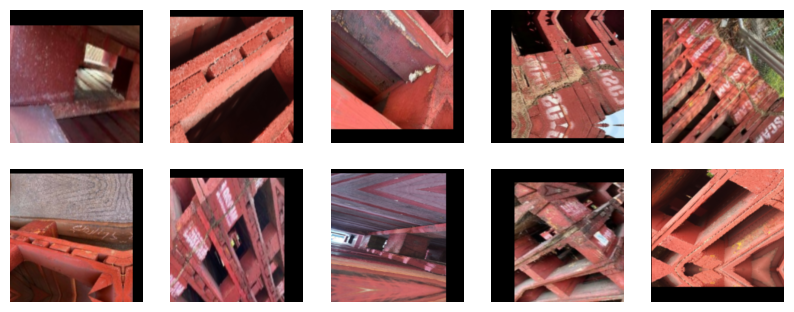

In [ ]:
# Function to plot images after applying augmentation
def plot_images(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy())
            plt.axis("off")

# Plot random images from train_ds
plot_images(train_ds, num_images=10)
plt.show()

In [ ]:
# Function to check image size in train_ds
def check_image_size(dataset):
    for images, _ in dataset.take(1):  # Take the first batch
        print(f"Training Image shape: {images.shape}")

# Check the size of the images
check_image_size(train_ds)


Training Image shape: (16, 224, 224, 3)


In [ ]:
# Function to count total number of images train_ds
def count_images(dataset):
    total_images = 0
    for images, _ in dataset:
        batch_size = images.shape[0]
        total_images += batch_size
    return total_images

# Count the total number of images
total_images = count_images(train_ds)
print(f"Total number of images in train dataset: {total_images}")

Total number of images in train dataset: 828


## Over Sampling

In [ ]:
# Function to convert dataset to NumPy arrays
def dataset_to_numpy(dataset):
    images_list = []
    labels_list = []

    for images, labels in dataset:
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())

    images_array = np.concatenate(images_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    return images_array, labels_array

# Convert train_ds to NumPy arrays
x_train_np, y_train_np = dataset_to_numpy(train_ds)

print("x_ train Images shape:", x_train_np.shape)
print("y_ train shape:", y_train_np.shape)

# Convert val_ds to NumPy arrays
x_val_np, y_val_np = dataset_to_numpy(val_ds)

print("x_ val Images shape:", x_val_np.shape)
print("y_ val shape:", y_val_np.shape)

# Convert test_ds to NumPy arrays
x_test_np, y_test_np = dataset_to_numpy(test_ds)

print("x_ test Images shape:", x_test_np.shape)
print("y_ test shape:", y_test_np.shape)

x_ train Images shape: (828, 224, 224, 3)
y_ train shape: (828,)
x_ val Images shape: (177, 224, 224, 3)
y_ val shape: (177,)
x_ test Images shape: (177, 224, 224, 3)
y_ test shape: (177,)


In [ ]:
# Apply RandomOverSampler to training set data
def apply_random_oversampling(images, labels):
    ros = RandomOverSampler(random_state=42)
    # Reshape images to 2D (samples, features) for the oversampler
    num_samples = images.shape[0]
    image_flattened = images.reshape(num_samples, -1)

    # Apply oversampling
    X_resampled, y_resampled = ros.fit_resample(image_flattened, labels)

    # Reshape images back to original shape
    images_resampled = X_resampled.reshape(-1, *images.shape[1:])

    return images_resampled, y_resampled

# Apply oversampling to NumPy arrays
oversampled_x_train, oversampled_y_train = apply_random_oversampling(x_train_np, y_train_np)

In [ ]:
print(oversampled_x_train.shape)

(1156, 224, 224, 3)


In [ ]:
# Summary number of data after applying over sampling
# Define class names
class_names = {
    0: 'damage',
    1: 'good',
}

# Function to count images per class and map labels to class names
def count_images_per_class(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_name_counts = {class_names.get(label, str(label)): count for label, count in zip(unique_labels, counts)}
    return label_name_counts

# Count images per class in the oversampled dataset
class_counts = count_images_per_class(oversampled_y_train)

# Print class counts
print("Image counts per class after oversampling:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Image counts per class after oversampling:
damage: 578 images
good: 578 images


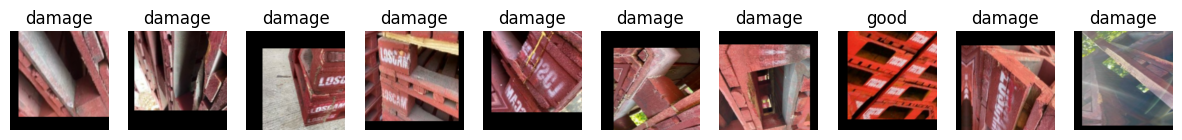

In [ ]:
# Function to plot images after over sampling
def plot_images(images, labels, class_names, num_images=10):
    plt.figure(figsize=(15, 10))

    # Randomly sample images to plot
    indices = np.random.choice(len(images), num_images, replace=False)

    for i, idx in enumerate(indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(class_names.get(labels[idx], str(labels[idx])))
        plt.axis('off')

    plt.show()

# Plot a subset of images from the oversampled dataset
plot_images(oversampled_x_train, oversampled_y_train, class_names)

## Summary data set to train the models **

In [ ]:
#1. Training Data
#  - Use oversampled_x_train, oversampled_y_train (NumPy arrays)
print(f'Training data shape: {oversampled_x_train.shape}, {oversampled_y_train.shape}')
# Count images per class in the oversampled dataset
class_counts_train = count_images_per_class(oversampled_y_train)

# Print class counts
print("Image counts per class of training set:")
for class_name, count in class_counts_train.items():
    print(f"{class_name}: {count} images")

print('\n')

#2. Validation Data
#  - Use x_val_np, y_val_np  (NumPy arrays)
print(f'Validation data shape: {x_val_np.shape}, {y_val_np.shape}')
# Count images per class
class_counts_val = count_images_per_class(y_val_np)

# Print class counts
print("Image counts per class of validation set:")
for class_name, count in class_counts_val.items():
    print(f"{class_name}: {count} images")

print('\n')

#3. Test Data
#  - Use x_test_np, y_test_np  (NumPy arrays)
print(f'Test data shape: {x_test_np.shape}, {y_test_np.shape}')
# Count images per class
class_counts_test = count_images_per_class(y_test_np)

# Print class counts
print("Image counts per class of test set:")
for class_name, count in class_counts_test.items():
    print(f"{class_name}: {count} images")



Training data shape: (1156, 224, 224, 3), (1156,)
Image counts per class of training set:
damage: 578 images
good: 578 images


Validation data shape: (177, 224, 224, 3), (177,)
Image counts per class of validation set:
damage: 123 images
good: 54 images


Test data shape: (177, 224, 224, 3), (177,)
Image counts per class of test set:
damage: 123 images
good: 54 images


# Model Development

## Load feature extractor and construct the model

In [ ]:
from transformers import TFDeiTModel

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("facebook/deit-base-distilled-patch16-224")
model = TFDeiTModel.from_pretrained("facebook/deit-base-distilled-patch16-224")

model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/350M [00:00<?, ?B/s]

Some layers from the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing TFDeiTModel: ['cls_classifier', 'distillation_classifier']
- This IS expected if you are initializing TFDeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit/pooler/dense/bias:0', 'deit/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_dei_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deit (TFDeiTMainLayer)      multiple                  86390784  
                                                                 
Total params: 86390784 (329.55 MB)
Trainable params: 86390784 (329.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import tensorflow as tf

batch_size = 16  # Adjust this value based on your GPU memory

# Iterate over your data in batches
for i in range(0, oversampled_x_train.shape[0], batch_size):
    batch_inputs = image_processor(oversampled_x_train[i:i+batch_size], return_tensors="tf")
    batch_outputs = model(**batch_inputs)

    # Process the outputs for this batch (e.g., extract last hidden states)
    batch_last_hidden_states = batch_outputs.last_hidden_state
    print(list(batch_last_hidden_states.shape))

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 768]
[16, 198, 

In [ ]:
# Freeze all layers in the feature extractor
model.trainable = False
model.summary()

Model: "tf_dei_t_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deit (TFDeiTMainLayer)      multiple                  86390784  
                                                                 
Total params: 86390784 (329.55 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 86390784 (329.55 MB)
_________________________________________________________________


In [ ]:
# An input layer
img_inputs = tf.keras.layers.Input(shape=(3,224,224), name='img_inputs', dtype='float32')

# Convert KerasTensor to EagerTensor
# A lambda layer is used to perform the conversion within the Keras model
vit_features = tf.keras.layers.Lambda(lambda x: model(x).last_hidden_state)(img_inputs)

# Classifier head
#cls_outputs_m2 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m2')(vit_features[:, 0, :])

# Construct the model
#model2 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m2])
#model2.summary()

## Prepare data for model

In [ ]:
# Change images from channel-last (default of Keras and TensorFlow) to channel-first (required by Huggingface's ViT)
x_train2 = np.moveaxis(oversampled_x_train, -1, 1)
x_test2 = np.moveaxis(x_test_np, -1, 1)
x_val2 = np.moveaxis(x_val_np, -1, 1)

# Inspect the dataset
print( f"x_train2: type={type(x_train2)} , dtype={x_train2.dtype} , shape={x_train2.shape} , min={x_train2.min(axis=None)} , max={x_train2.max(axis=None)}" )
print( f"x_test2: type={type(x_test2)} , dtype={x_test2.dtype} , shape={x_test2.shape} , min={x_test2.min(axis=None)} , max={x_test2.max(axis=None)}"  )

x_train2: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(1156, 3, 224, 224) , min=0.0 , max=1.0
x_test2: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(177, 3, 224, 224) , min=0.0 , max=1.0


In [ ]:
x_train_vit = np.array( image_processor(x_train2,do_rescale = False)['pixel_values'] )
y_train_vit = oversampled_y_train
x_test_vit = np.array( image_processor(x_test2,do_rescale = False)['pixel_values'] )
y_test_vit = y_test_np
x_val_vit = np.array( image_processor(x_val2,do_rescale = False)['pixel_values'] )
y_val_vit = y_val_np

# Inspect the dataset
print( f"x_train_vit: type={type(x_train_vit)} , dtype={x_train_vit.dtype} , shape={x_train_vit.shape} , min={x_train_vit.min(axis=None)} , max={x_train_vit.max(axis=None)}" )
print( f"y_train_vit: type={type(y_train_vit)} , dtype={y_train_vit.dtype} , shape={y_train_vit.shape} , min={min(y_train_vit)} , max={max(y_train_vit)}" )
print( f"x_test_vit: type={type(x_test_vit)} , dtype={x_test_vit.dtype} , shape={x_test_vit.shape} , min={x_test_vit.min(axis=None)} , max={x_test_vit.max(axis=None)}"  )
print( f"y_test_vit: type={type(y_test_vit)} , dtype={y_test_vit.dtype} , shape={y_test_vit.shape} , min={min(y_test_vit)} , max={max(y_test_vit)}" )
print( f"x_val_vit: type={type(x_val_vit)} , dtype={x_val_vit.dtype} , shape={x_val_vit.shape} , min={x_val_vit.min(axis=None)} , max={x_val_vit.max(axis=None)}"  )
print( f"y_val_vit: type={type(y_val_vit)} , dtype={y_val_vit.dtype} , shape={y_val_vit.shape} , min={min(y_val_vit)} , max={max(y_val_vit)}" )

x_train_vit: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(1156, 3, 224, 224) , min=-2.1179039478302 , max=2.640000104904175
y_train_vit: type=<class 'numpy.ndarray'> , dtype=int32 , shape=(1156,) , min=0 , max=1
x_test_vit: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(177, 3, 224, 224) , min=-2.1179039478302 , max=2.640000104904175
y_test_vit: type=<class 'numpy.ndarray'> , dtype=int32 , shape=(177,) , min=0 , max=1
x_val_vit: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(177, 3, 224, 224) , min=-2.1179039478302 , max=2.640000104904175
y_val_vit: type=<class 'numpy.ndarray'> , dtype=int32 , shape=(177,) , min=0 , max=1


In [ ]:
# Change data to to one-hot encoding to match the model's output shape
from tensorflow.keras.utils import to_categorical


# Convert y_test_vit to one-hot encoding
y_test_vit_encoded = to_categorical(y_test_vit, num_classes=2)
y_train_vit_encoded = to_categorical(y_train_vit, num_classes=2)
y_val_vit_encoded = to_categorical(y_val_vit, num_classes=2)

In [ ]:
y_test_vit.shape

(177,)

In [ ]:
y_test_vit_encoded.shape

(177, 2)

In [ ]:
x_test_vit.shape

(177, 3, 224, 224)

## Fine tune the model

In [ ]:
import tensorflow as tf

# Force eager execution to avoid the error
tf.config.run_functions_eagerly(True)

In [ ]:
# Evaluate the model BEFORE finetuning
model2.evaluate(x_test_vit, y_test_vit_encoded)

In [ ]:
import tensorflow as tf

# Disable eager execution
tf.config.run_functions_eagerly(False)

# Check GPU availability and memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Use more memory or let Tensorflow manage it
        # tf.config.set_logical_device_configuration(
        #     gpus[0],
        #     [tf.config.LogicalDeviceConfiguration(memory_limit=2048)] # Increase if needed
        # )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Clear the session to release any held resources
tf.keras.backend.clear_session()


In [ ]:
# Re-enable eager execution
tf.config.run_functions_eagerly(True)

----------------------------------------------------------------------

##Add dense 512 & 256 to model

###Round1

In [ ]:
import tensorflow as tf

# Disable eager execution
tf.config.run_functions_eagerly(False)

# Check GPU availability and memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Use more memory or let Tensorflow manage it
        # tf.config.set_logical_device_configuration(
        #     gpus[0],
        #     [tf.config.LogicalDeviceConfiguration(memory_limit=2048)] # Increase if needed
        # )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Clear the session to release any held resources
tf.keras.backend.clear_session()

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# An input layer
#img_inputs = tf.keras.layers.Input(shape=(3,224,224), name='img_inputs', dtype='float32')

# Convert KerasTensor to EagerTensor
# A lambda layer is used to perform the conversion within the Keras model
#vit_features = tf.keras.layers.Lambda(lambda x: model(x).last_hidden_state)(img_inputs)

# Classifier head
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dense_512)
cls_outputs_m4 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m4')(dense_256)

# Construct the model
model4 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m4])
model4.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m4 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 603ms/step - acc: 0.2176 - loss: 0.9832


[0.982110321521759, 0.23728813230991364]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history4 = model4.fit(x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - acc: 0.8659 - loss: 0.3038 - val_acc: 0.9944 - val_loss: 0.0155
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - acc: 0.9851 - loss: 0.0373 - val_acc: 0.9944 - val_loss: 0.0244
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - acc: 1.0000 - loss: 0.0027 - val_acc: 0.9944 - val_loss: 0.0148
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - acc: 1.0000 - loss: 7.5853e-04 - val_acc: 0.9944 - val_loss: 0.0132
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - acc: 1.0000 - loss: 3.2652e-04 - val_acc: 0.9944 - val_loss: 0.0151
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - acc: 1.0000 - loss: 2.4229e-04 - val_acc: 0.9944 - val_loss: 0.0157
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - acc: 1.0000 - loss: 1.8663e-04 - val_acc: 0.9944 - val_loss: 0.0159
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - acc: 1.0000 - loss: 1.3704e-04 - val_acc: 0.9944 - val_loss: 0.0163
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━

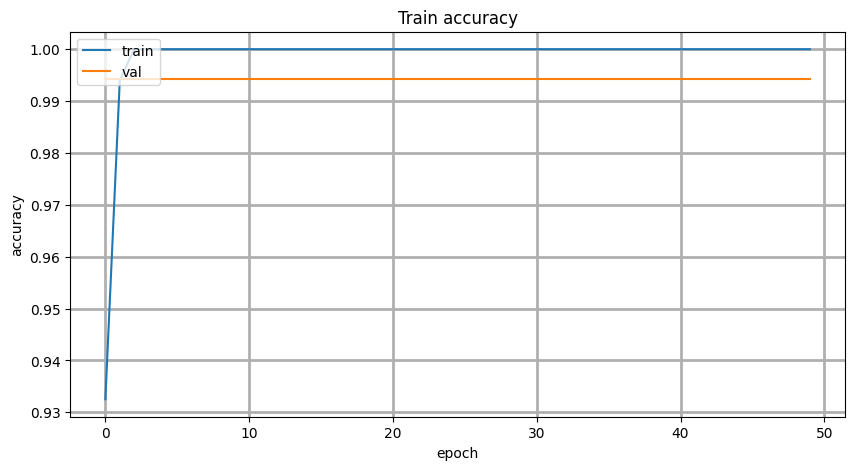

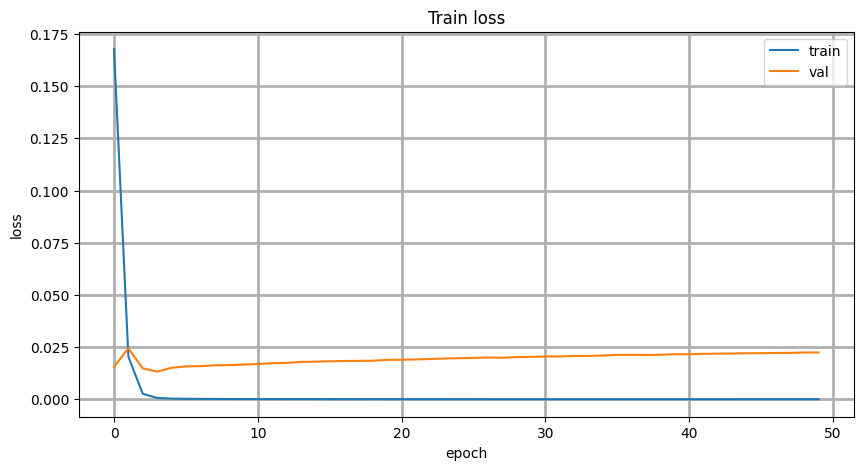

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - acc: 0.9891 - loss: 0.0178


[0.02827323041856289, 0.9830508232116699]

###Round2

In [ ]:
import tensorflow as tf

# Disable eager execution
tf.config.run_functions_eagerly(False)

# Check GPU availability and memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Use more memory or let Tensorflow manage it
        # tf.config.set_logical_device_configuration(
        #     gpus[0],
        #     [tf.config.LogicalDeviceConfiguration(memory_limit=2048)] # Increase if needed
        # )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Clear the session to release any held resources
tf.keras.backend.clear_session()

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# An input layer
#img_inputs = tf.keras.layers.Input(shape=(3,224,224), name='img_inputs', dtype='float32')

# Convert KerasTensor to EagerTensor
# A lambda layer is used to perform the conversion within the Keras model
#vit_features = tf.keras.layers.Lambda(lambda x: model(x).last_hidden_state)(img_inputs)

# Classifier head
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dense_512)
cls_outputs_m4 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m4')(dense_256)

# Construct the model
model4 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m4])
model4.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m4 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 636ms/step - acc: 0.6109 - loss: 0.7616


[0.759080708026886, 0.5932203531265259]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history4 = model4.fit(x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 218ms/step - acc: 0.8254 - loss: 0.3856 - val_acc: 1.0000 - val_loss: 0.0245
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - acc: 0.9917 - loss: 0.0195 - val_acc: 0.9944 - val_loss: 0.0187
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - acc: 1.0000 - loss: 0.0015 - val_acc: 0.9944 - val_loss: 0.0193
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - acc: 1.0000 - loss: 8.9788e-04 - val_acc: 0.9944 - val_loss: 0.0161
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 1.0000 - loss: 4.0428e-04 - val_acc: 0.9944 - val_loss: 0.0173
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 1.0000 - loss: 2.8445e-04 - val_acc: 0.9944 - val_loss: 0.0181
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 1.0000 - loss: 1.7573e-04 - val_acc: 0.9944 - val_loss: 0.0190
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 1.0000 - loss: 1.4338e-04 - val_acc: 0.9944 - val_loss: 0.0190
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━

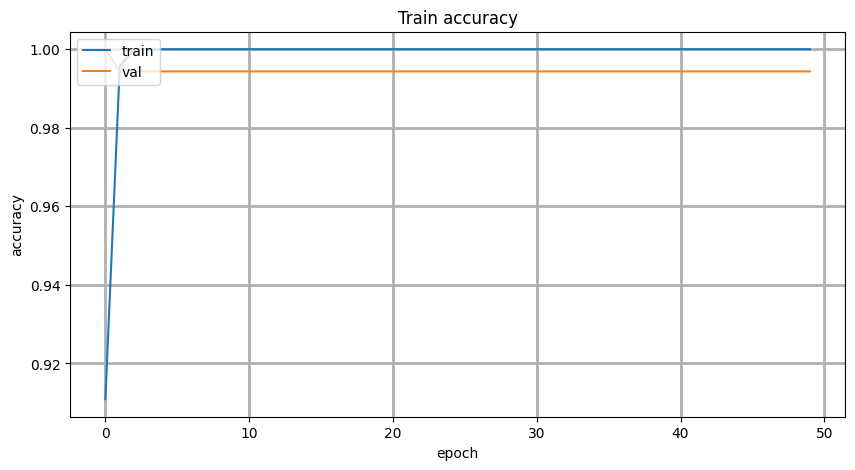

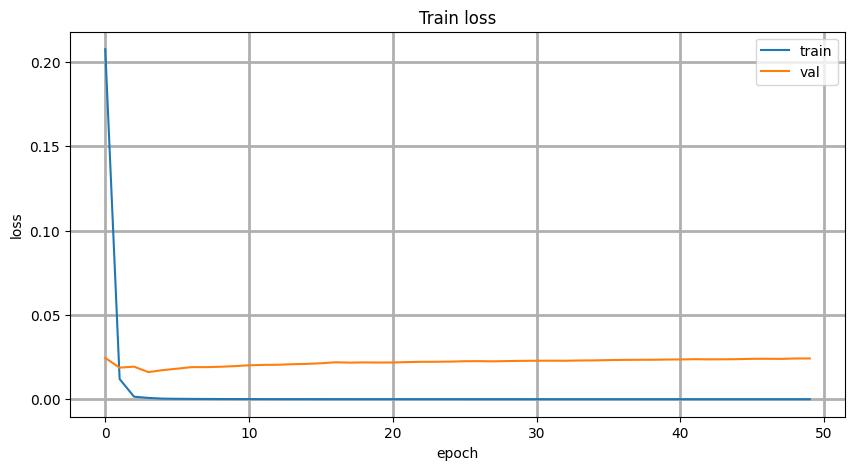

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - acc: 0.9891 - loss: 0.0230


[0.03457031026482582, 0.9830508232116699]

###Round3

In [ ]:
import tensorflow as tf

# Disable eager execution
tf.config.run_functions_eagerly(False)

# Check GPU availability and memory usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Use more memory or let Tensorflow manage it
        # tf.config.set_logical_device_configuration(
        #     gpus[0],
        #     [tf.config.LogicalDeviceConfiguration(memory_limit=2048)] # Increase if needed
        # )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Clear the session to release any held resources
tf.keras.backend.clear_session()

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# An input layer
#img_inputs = tf.keras.layers.Input(shape=(3,224,224), name='img_inputs', dtype='float32')

# Convert KerasTensor to EagerTensor
# A lambda layer is used to perform the conversion within the Keras model
#vit_features = tf.keras.layers.Lambda(lambda x: model(x).last_hidden_state)(img_inputs)

# Classifier head
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dense_512)
cls_outputs_m4 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m4')(dense_256)

# Construct the model
model4 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m4])
model4.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m4 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 632ms/step - acc: 0.6266 - loss: 0.7028


[0.7084504961967468, 0.604519784450531]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history4 = model4.fit(x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 225ms/step - acc: 0.8523 - loss: 0.3159 - val_acc: 0.9944 - val_loss: 0.0205
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 0.9885 - loss: 0.0366 - val_acc: 0.9887 - val_loss: 0.0223
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 1.0000 - loss: 0.0035 - val_acc: 0.9774 - val_loss: 0.0344
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 1.0000 - loss: 0.0016 - val_acc: 0.9944 - val_loss: 0.0201
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 1.0000 - loss: 3.1729e-04 - val_acc: 0.9944 - val_loss: 0.0191
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 1.0000 - loss: 2.3216e-04 - val_acc: 0.9944 - val_loss: 0.0199
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 1.0000 - loss: 1.6616e-04 - val_acc: 0.9944 - val_loss: 0.0205
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 1.0000 - loss: 1.3684e-04 - val_acc: 0.9944 - val_loss: 0.0208
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4

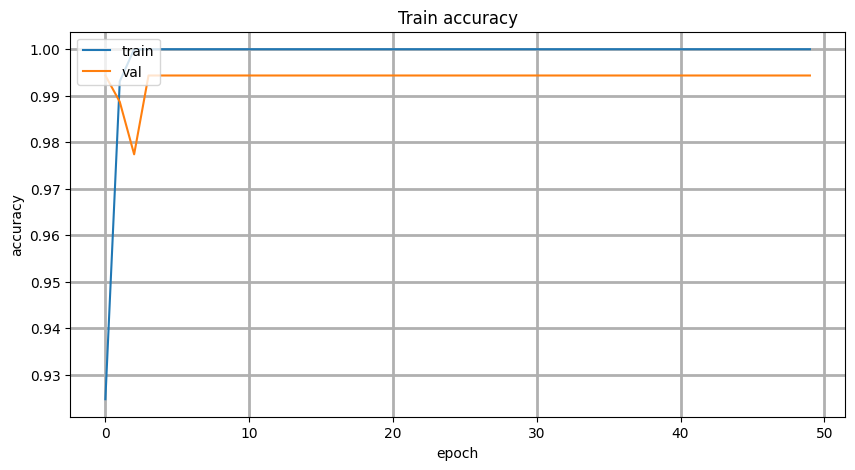

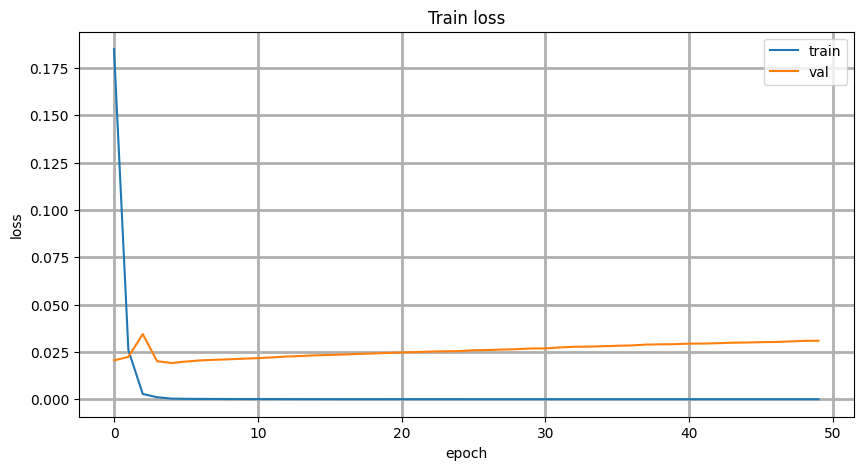

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model4.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - acc: 0.9891 - loss: 0.0265


[0.035685885697603226, 0.9830508232116699]

-----

##Add dense 512 & 256 with BatchNorm to model

###Round1

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(bn_512)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)

cls_outputs_m5 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m5')(bn_256)

# Construct the model
model5 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m5])
model5.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_1 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m5 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,642 (2.02 MB)

 Trainable params: 527,106 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 647ms/step - acc: 0.4388 - loss: 0.7671


[0.7790821194648743, 0.4237288236618042]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history5 = model5.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - acc: 0.8327 - loss: 0.3405 - val_acc: 0.9944 - val_loss: 0.0541
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 0.9998 - loss: 0.0153 - val_acc: 0.9944 - val_loss: 0.0248
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9991 - loss: 0.0070 - val_acc: 0.9944 - val_loss: 0.0306
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9984 - loss: 0.0101 - val_acc: 1.0000 - val_loss: 0.0101
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 1.0000 - loss: 0.0054 - val_acc: 0.9944 - val_loss: 0.0109
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9958 - loss: 0.0159 - val_acc: 0.9944 - val_loss: 0.0144
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9815 - loss: 0.0444 - val_acc: 0.9887 - val_loss: 0.0293
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9990 - loss: 0.0102 - val_acc: 0.9887 - val_loss: 0.0232
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - a

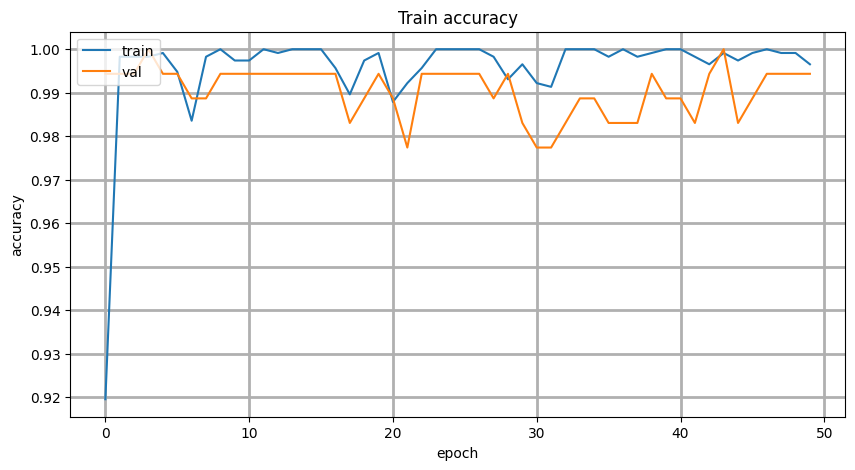

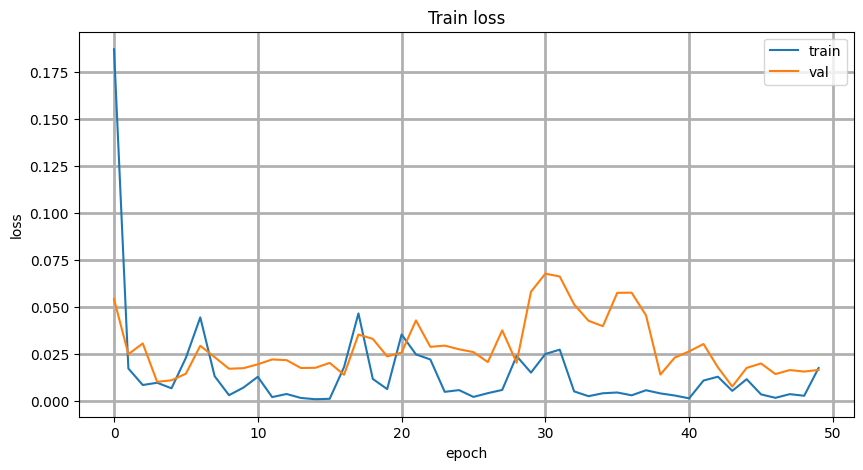

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - acc: 0.9773 - loss: 0.0368


[0.043666888028383255, 0.9774011373519897]

In [ ]:
#save model5
model5.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_3.h5')

###Round2

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(bn_512)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)

cls_outputs_m5 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m5')(bn_256)

# Construct the model
model5 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m5])
model5.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_2 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m5 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,642 (2.02 MB)

 Trainable params: 527,106 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 563ms/step - acc: 0.6737 - loss: 0.6841


[0.673009991645813, 0.6836158037185669]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history5 = model5.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 215ms/step - acc: 0.8534 - loss: 0.3345 - val_acc: 0.9831 - val_loss: 0.0592
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9982 - loss: 0.0213 - val_acc: 0.9887 - val_loss: 0.0269
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9992 - loss: 0.0103 - val_acc: 0.9944 - val_loss: 0.0256
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9980 - loss: 0.0092 - val_acc: 0.9944 - val_loss: 0.0218
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 1.0000 - loss: 0.0028 - val_acc: 0.9944 - val_loss: 0.0190
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9999 - loss: 0.0047 - val_acc: 0.9944 - val_loss: 0.0176
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9943 - loss: 0.0237 - val_acc: 0.9831 - val_loss: 0.0281
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9875 - loss: 0.0415 - val_acc: 0.9944 - val_loss: 0.0176
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - a

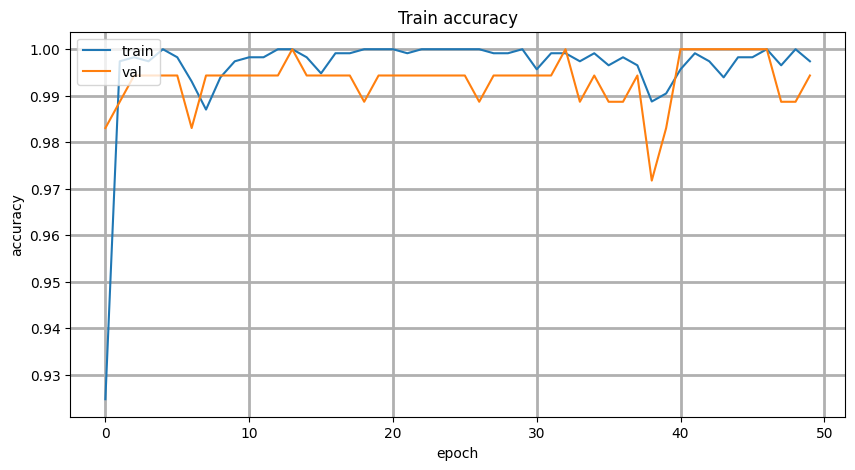

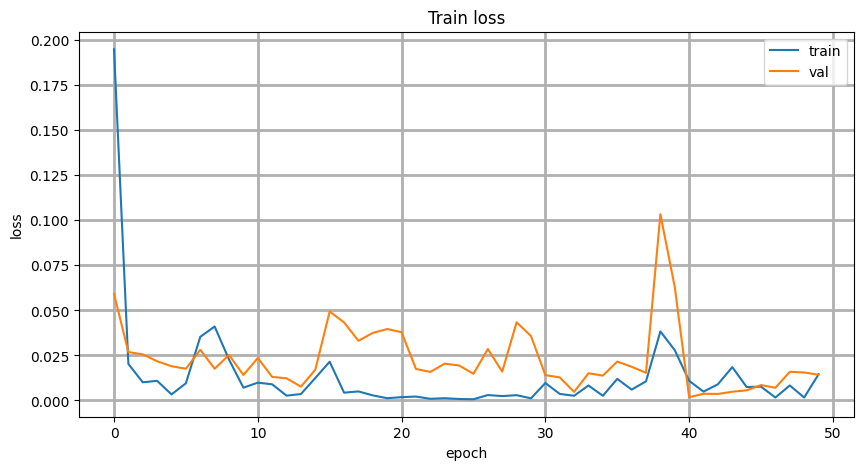

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - acc: 0.9939 - loss: 0.0344


[0.05566849187016487, 0.9887005686759949]

###Round3

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(bn_512)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)

cls_outputs_m5 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m5')(bn_256)

# Construct the model
model5 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m5])
model5.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_4 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m5 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,642 (2.02 MB)

 Trainable params: 527,106 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 545ms/step - acc: 0.5442 - loss: 0.7316


[0.7315388321876526, 0.5536723136901855]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history5 = model5.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 223ms/step - acc: 0.8327 - loss: 0.3405 - val_acc: 0.9944 - val_loss: 0.0541
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - acc: 0.9998 - loss: 0.0153 - val_acc: 0.9944 - val_loss: 0.0248
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9991 - loss: 0.0070 - val_acc: 0.9944 - val_loss: 0.0306
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9984 - loss: 0.0101 - val_acc: 1.0000 - val_loss: 0.0101
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 1.0000 - loss: 0.0054 - val_acc: 0.9944 - val_loss: 0.0109
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9958 - loss: 0.0159 - val_acc: 0.9944 - val_loss: 0.0144
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - acc: 0.9815 - loss: 0.0444 - val_acc: 0.9887 - val_loss: 0.0293
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9990 - loss: 0.0102 - val_acc: 0.9887 - val_loss: 0.0232
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - a

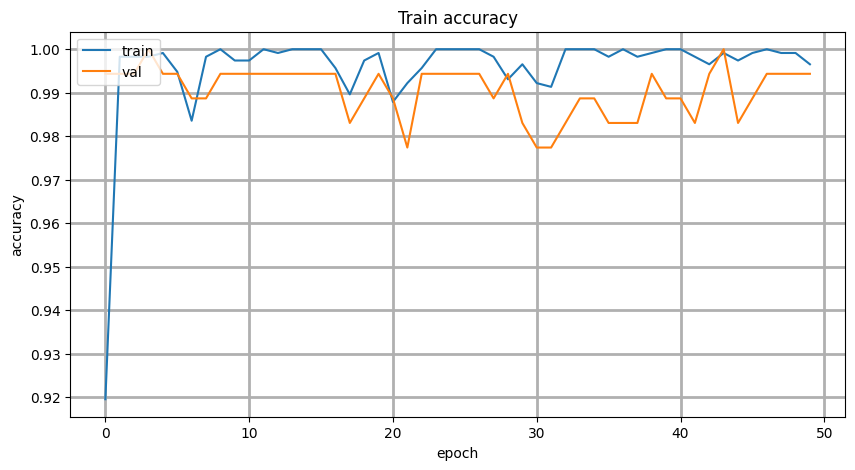

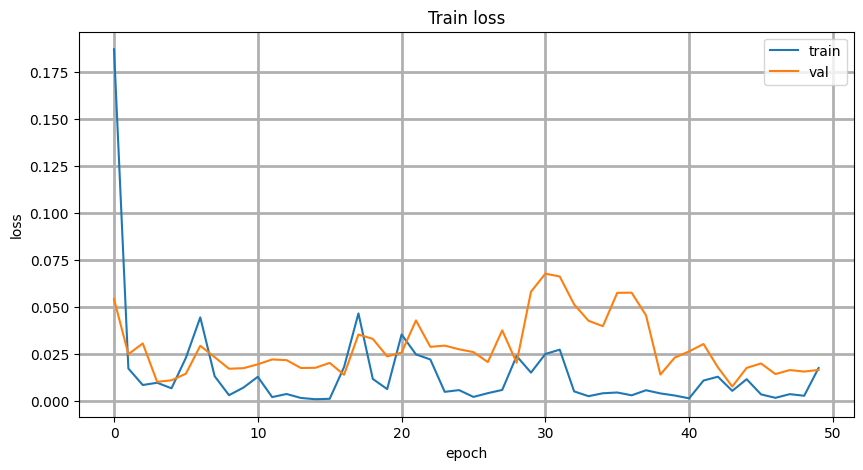

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model5.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - acc: 0.9773 - loss: 0.0368


[0.043666888028383255, 0.9774011373519897]

-----

##Add dense 512 & 256 with dropout 0.5 to model

###Round1

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout1 = tf.keras.layers.Dropout(0.5)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout1)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout2 = tf.keras.layers.Dropout(0.5)(dense_256)

cls_outputs_m6 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m6')(dropout2)

# Construct the model
model6 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m6])
model6.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_2 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m6 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
import tensorflow as tf

# Force eager execution to avoid the error
tf.config.run_functions_eagerly(True)

# Evaluate the model BEFORE finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - acc: 0.4800 - loss: 0.7284


[0.7354193329811096, 0.4689265489578247]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history6 = model6.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 681ms/step - acc: 0.7684 - loss: 0.5330 - val_acc: 0.9774 - val_loss: 0.0701
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 674ms/step - acc: 0.9631 - loss: 0.1150 - val_acc: 0.9887 - val_loss: 0.0578
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 675ms/step - acc: 0.9873 - loss: 0.0469 - val_acc: 0.9887 - val_loss: 0.0616
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 678ms/step - acc: 0.9926 - loss: 0.0276 - val_acc: 0.9887 - val_loss: 0.0389
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 677ms/step - acc: 0.9956 - loss: 0.0171 - val_acc: 0.9887 - val_loss: 0.0486
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 677ms/step - acc: 0.9976 - loss: 0.0111 - val_acc: 0.9887 - val_loss: 0.0479
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 678ms/step - acc: 0.9998 - loss: 0.0047 - val_acc: 0.9887 - val_loss: 0.0472
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 679ms/step - acc: 0.9996 - loss: 0.0040 - val_acc: 0.9887 - val_loss: 0.0508
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 677ms/

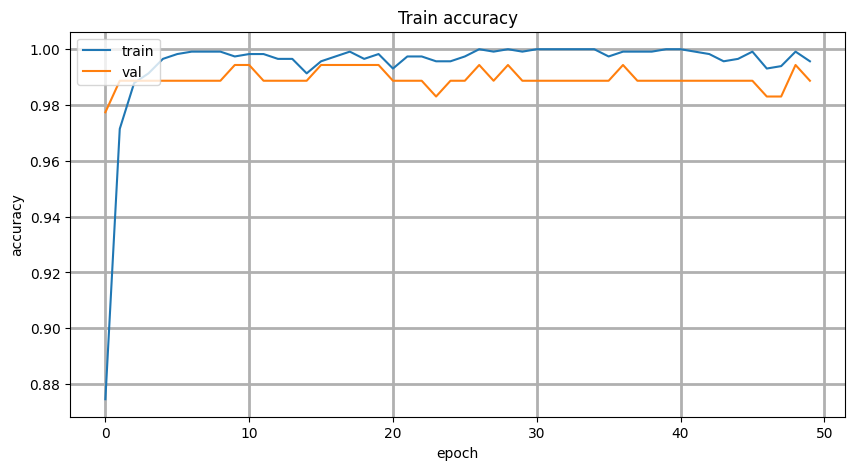

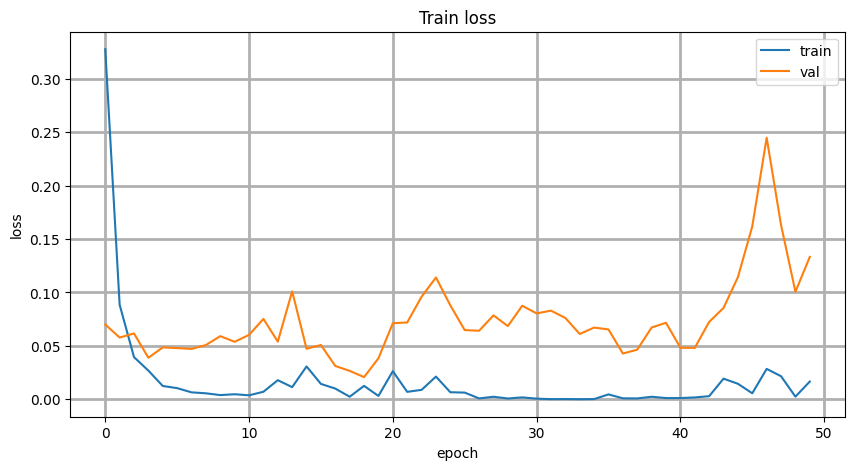

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - acc: 0.9741 - loss: 0.1853


[0.31869491934776306, 0.9774011373519897]

###Round2

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout1 = tf.keras.layers.Dropout(0.5)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout1)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout2 = tf.keras.layers.Dropout(0.5)(dense_256)

cls_outputs_m6 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m6')(dropout2)

# Construct the model
model6 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m6])
model6.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_3 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m6 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
import tensorflow as tf

# Force eager execution to avoid the error
tf.config.run_functions_eagerly(True)

# Evaluate the model BEFORE finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - acc: 0.5649 - loss: 0.7359


[0.7485148906707764, 0.5593220591545105]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history6 = model6.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 679ms/step - acc: 0.7896 - loss: 0.5478 - val_acc: 0.9944 - val_loss: 0.0332
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 680ms/step - acc: 0.9711 - loss: 0.0995 - val_acc: 0.9774 - val_loss: 0.0469
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 677ms/step - acc: 0.9919 - loss: 0.0396 - val_acc: 0.9887 - val_loss: 0.0368
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 681ms/step - acc: 0.9959 - loss: 0.0235 - val_acc: 0.9887 - val_loss: 0.0364
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 681ms/step - acc: 0.9949 - loss: 0.0152 - val_acc: 0.9887 - val_loss: 0.0436
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 678ms/step - acc: 0.9917 - loss: 0.0347 - val_acc: 0.9887 - val_loss: 0.0563
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 678ms/step - acc: 0.9960 - loss: 0.0097 - val_acc: 0.9887 - val_loss: 0.0762
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 688ms/step - acc: 0.9981 - loss: 0.0056 - val_acc: 0.9887 - val_loss: 0.0512
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 680ms/

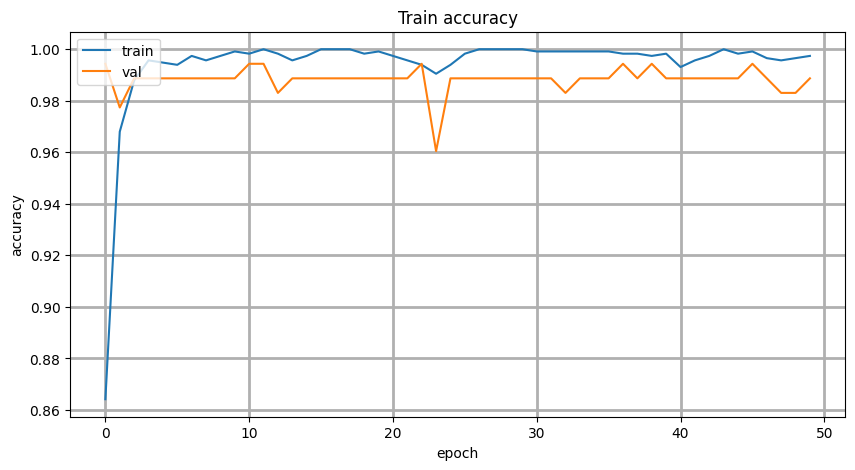

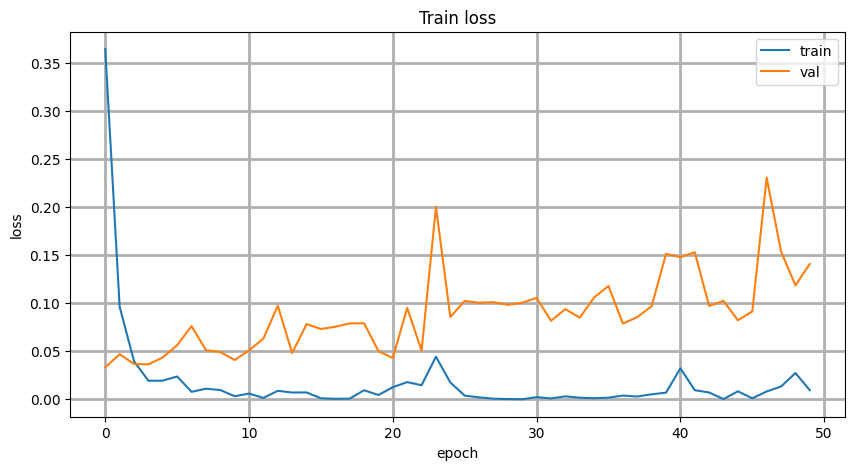

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - acc: 0.9866 - loss: 0.1041


[0.1482212394475937, 0.9887005686759949]

###Round3

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout1 = tf.keras.layers.Dropout(0.5)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout1)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout2 = tf.keras.layers.Dropout(0.5)(dense_256)

cls_outputs_m6 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m6')(dropout2)

# Construct the model
model6 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m6])
model6.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_4 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m6 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
import tensorflow as tf

# Force eager execution to avoid the error
tf.config.run_functions_eagerly(True)

# Evaluate the model BEFORE finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - acc: 0.4236 - loss: 0.7808


[0.7809901833534241, 0.4350282549858093]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history6 = model6.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 693ms/step - acc: 0.7642 - loss: 0.5379 - val_acc: 0.9831 - val_loss: 0.0498
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 680ms/step - acc: 0.9718 - loss: 0.0906 - val_acc: 0.9887 - val_loss: 0.0360
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 680ms/step - acc: 0.9765 - loss: 0.0615 - val_acc: 0.9661 - val_loss: 0.0773
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 679ms/step - acc: 0.9898 - loss: 0.0382 - val_acc: 0.9887 - val_loss: 0.0320
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 678ms/step - acc: 0.9951 - loss: 0.0127 - val_acc: 0.9887 - val_loss: 0.0371
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 676ms/step - acc: 0.9980 - loss: 0.0081 - val_acc: 0.9887 - val_loss: 0.0395
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 685ms/step - acc: 0.9924 - loss: 0.0194 - val_acc: 0.9944 - val_loss: 0.0367
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 682ms/step - acc: 0.9947 - loss: 0.0221 - val_acc: 0.9944 - val_loss: 0.0356
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 25s 677ms/

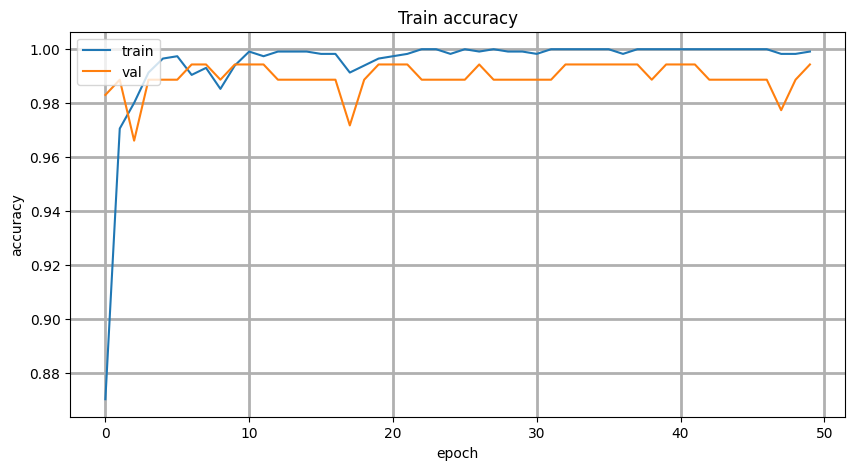

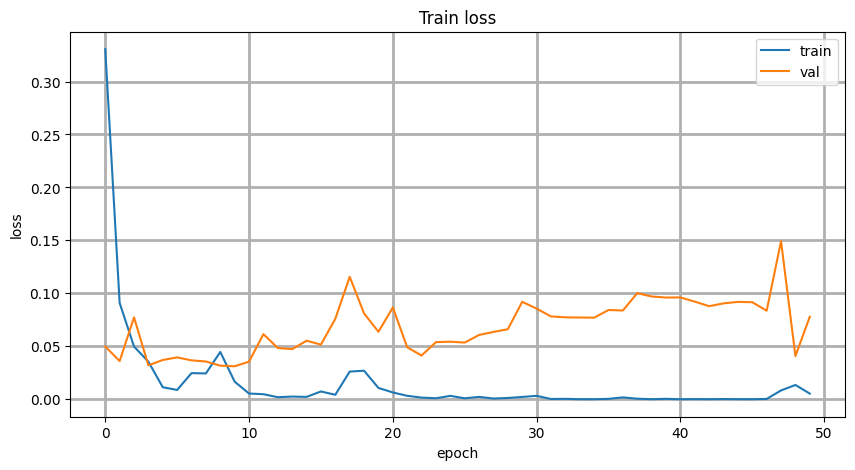

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history6.history['acc'])
plt.plot(history6.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model6.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - acc: 0.9897 - loss: 0.0644


[0.15164534747600555, 0.9830508232116699]

##Add dense 512 & 256 with dropout 0.25 to model

###Round 1

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout3 = tf.keras.layers.Dropout(0.25)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout3)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout4 = tf.keras.layers.Dropout(0.25)(dense_256)

cls_outputs_m7 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m7')(dropout4)

# Construct the model
model7 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m7])
model7.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_11 (GetItem)                │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m7 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 634ms/step - acc: 0.3274 - loss: 0.9718


[0.9698196053504944, 0.33898305892944336]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history7 = model7.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 28s 257ms/step - acc: 0.8050 - loss: 0.4199 - val_acc: 0.9831 - val_loss: 0.0724
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - acc: 0.9820 - loss: 0.0629 - val_acc: 0.9887 - val_loss: 0.0317
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9935 - loss: 0.0271 - val_acc: 0.9887 - val_loss: 0.0408
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9965 - loss: 0.0085 - val_acc: 0.9887 - val_loss: 0.0489
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9992 - loss: 0.0034 - val_acc: 0.9944 - val_loss: 0.0436
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - acc: 1.0000 - loss: 0.0017 - val_acc: 0.9887 - val_loss: 0.0462
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 1.0000 - loss: 5.7979e-04 - val_acc: 0.9944 - val_loss: 0.0470
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 1.0000 - loss: 4.5918e-04 - val_acc: 0.9944 - val_loss: 0.0486
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/

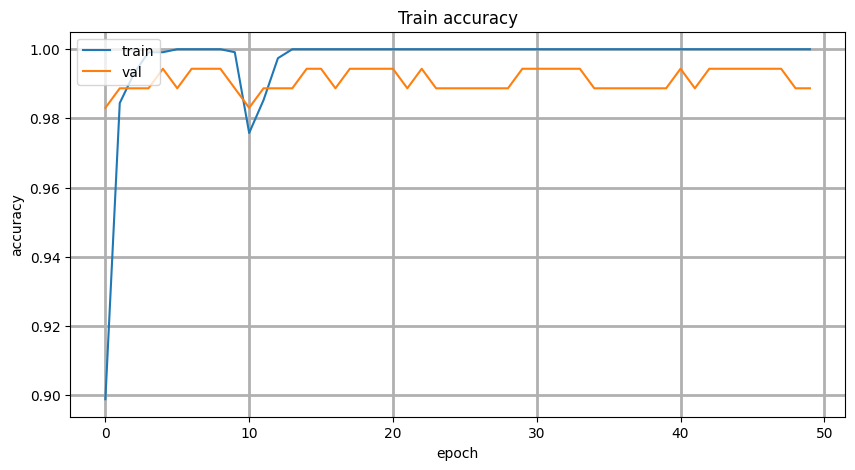

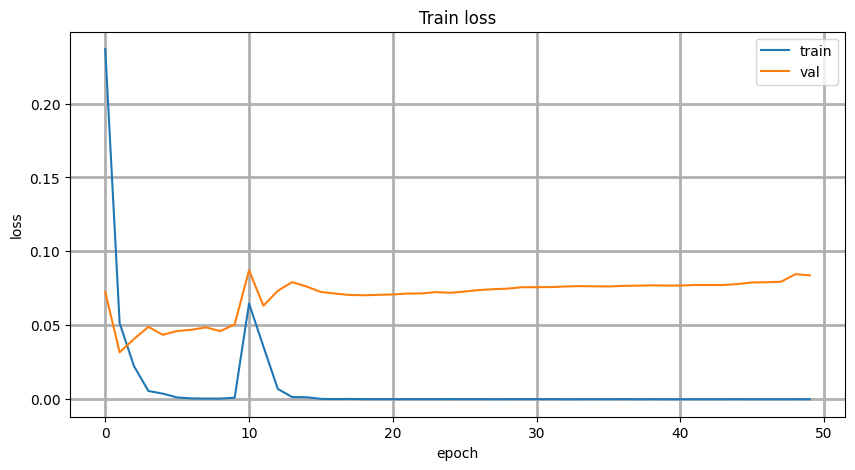

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - acc: 0.9866 - loss: 0.1037


[0.08844710886478424, 0.9887005686759949]

In [ ]:
#save model7
model7.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_4_2.h5')

###Round 2

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout3 = tf.keras.layers.Dropout(0.25)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout3)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout4 = tf.keras.layers.Dropout(0.25)(dense_256)

cls_outputs_m7 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m7')(dropout4)

# Construct the model
model7 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m7])
model7.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_12 (GetItem)                │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m7 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 685ms/step - acc: 0.4415 - loss: 0.9426


[0.9539551734924316, 0.40112993121147156]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history7 = model7.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 241ms/step - acc: 0.8311 - loss: 0.3992 - val_acc: 0.9887 - val_loss: 0.0322
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - acc: 0.9831 - loss: 0.0596 - val_acc: 0.9944 - val_loss: 0.0240
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9934 - loss: 0.0187 - val_acc: 0.9944 - val_loss: 0.0459
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 1.0000 - loss: 0.0061 - val_acc: 0.9887 - val_loss: 0.0473
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9986 - loss: 0.0055 - val_acc: 0.9944 - val_loss: 0.0443
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9980 - loss: 0.0075 - val_acc: 0.9887 - val_loss: 0.0378
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - acc: 1.0000 - loss: 0.0031 - val_acc: 0.9887 - val_loss: 0.0259
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 1.0000 - loss: 3.1314e-04 - val_acc: 0.9887 - val_loss: 0.0251
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step

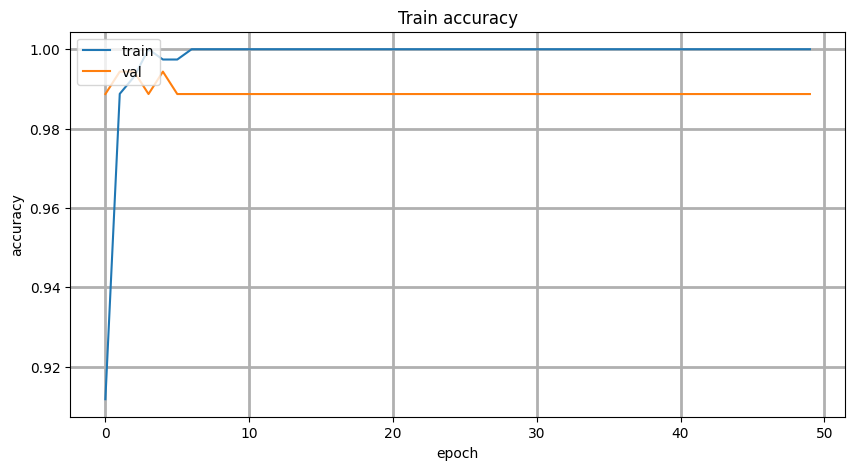

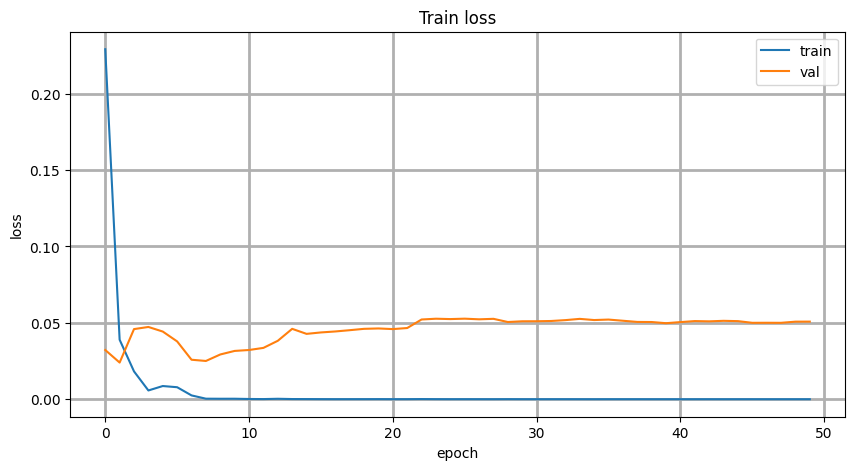

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - acc: 0.9866 - loss: 0.1255


[0.0853179469704628, 0.9887005686759949]

In [ ]:
#save model7
model7.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_4_2.h5')

###Round 3

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
#bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout3 = tf.keras.layers.Dropout(0.25)(dense_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout3)
#bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout4 = tf.keras.layers.Dropout(0.25)(dense_256)

cls_outputs_m7 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m7')(dropout4)

# Construct the model
model7 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m7])
model7.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_13 (GetItem)                │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m7 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,570 (2.00 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 671ms/step - acc: 0.2854 - loss: 1.0737


[1.067423701286316, 0.31073445081710815]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history7 = model7.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 245ms/step - acc: 0.7955 - loss: 0.4236 - val_acc: 0.9831 - val_loss: 0.0408
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - acc: 0.9965 - loss: 0.0317 - val_acc: 0.9887 - val_loss: 0.0444
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9972 - loss: 0.0161 - val_acc: 0.9944 - val_loss: 0.0305
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9981 - loss: 0.0166 - val_acc: 0.9831 - val_loss: 0.0476
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9982 - loss: 0.0044 - val_acc: 0.9887 - val_loss: 0.0328
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9990 - loss: 0.0027 - val_acc: 0.9944 - val_loss: 0.0433
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 1.0000 - loss: 0.0024 - val_acc: 0.9887 - val_loss: 0.0369
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 1.0000 - loss: 3.6763e-04 - val_acc: 0.9887 - val_loss: 0.0411
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step

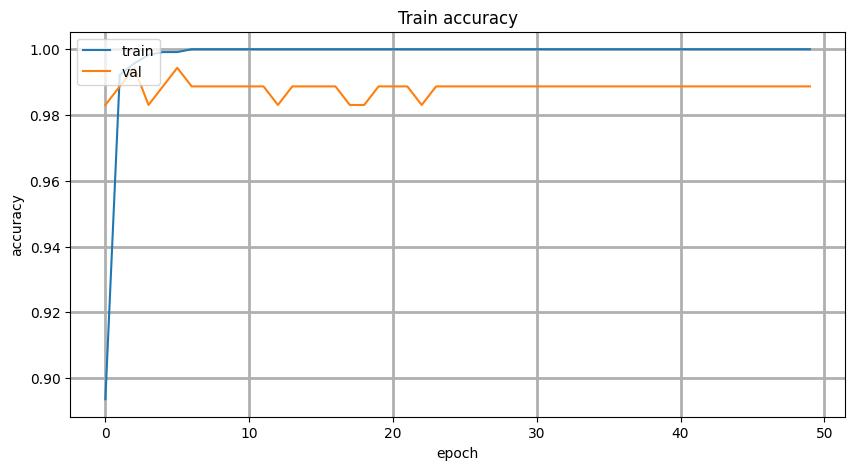

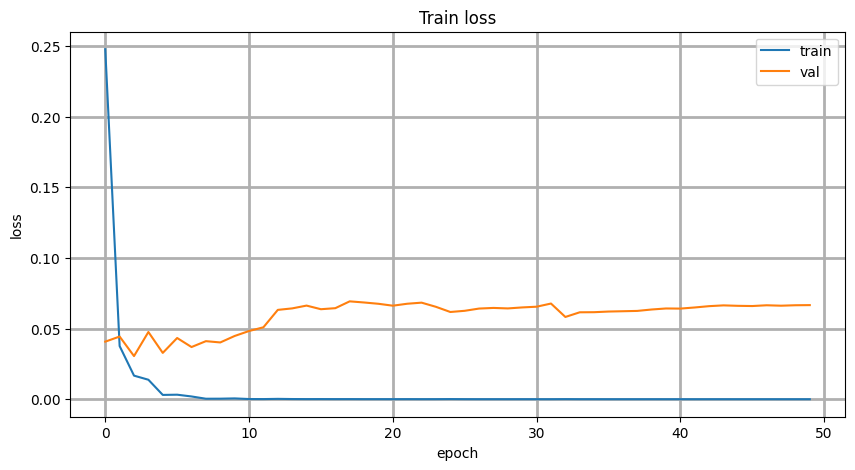

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history7.history['acc'])
plt.plot(history7.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model7.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - acc: 0.9866 - loss: 0.1350


[0.08872565627098083, 0.9887005686759949]

In [ ]:
#save model7
model7.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_4_2.h5')

##Add dense 512 & 256 with dropout 0.25 with BatchNorm to model

###Round 1

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout5 = tf.keras.layers.Dropout(0.25)(bn_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout5)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout6 = tf.keras.layers.Dropout(0.25)(bn_256)

cls_outputs_m8 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m8')(dropout6)

# Construct the model
model8 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m8])
model8.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_3 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m8 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,642 (2.02 MB)

 Trainable params: 527,106 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - acc: 0.6830 - loss: 0.7113


[0.7017024159431458, 0.6836158037185669]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history8 = model8.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 714ms/step - acc: 0.8331 - loss: 0.3918 - val_acc: 0.9944 - val_loss: 0.0484
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 710ms/step - acc: 0.9883 - loss: 0.0465 - val_acc: 0.9887 - val_loss: 0.0690
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 707ms/step - acc: 0.9975 - loss: 0.0220 - val_acc: 0.9887 - val_loss: 0.0452
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 709ms/step - acc: 0.9989 - loss: 0.0123 - val_acc: 0.9887 - val_loss: 0.0517
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 706ms/step - acc: 0.9999 - loss: 0.0070 - val_acc: 0.9887 - val_loss: 0.0476
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 713ms/step - acc: 0.9988 - loss: 0.0091 - val_acc: 0.9887 - val_loss: 0.0590
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 720ms/step - acc: 0.9987 - loss: 0.0105 - val_acc: 0.9831 - val_loss: 0.0663
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 713ms/step - acc: 0.9995 - loss: 0.0042 - val_acc: 0.9831 - val_loss: 0.0599
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 716ms/

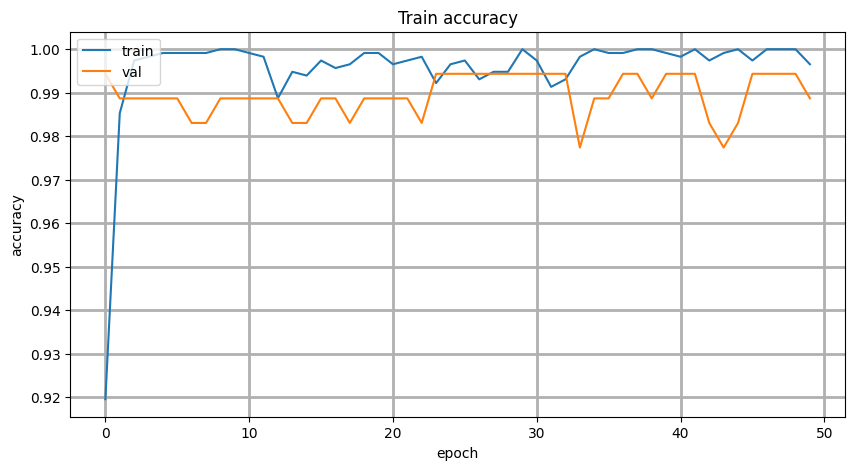

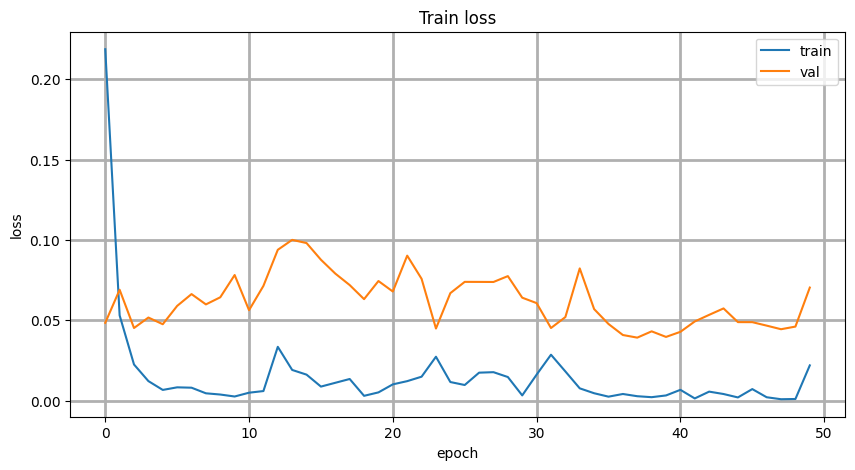

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history8.history['acc'])
plt.plot(history8.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - acc: 0.9643 - loss: 0.1194


[0.1145959421992302, 0.9661017060279846]

In [ ]:
#save model8
model8.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_5.h5')

###Round 2

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout5 = tf.keras.layers.Dropout(0.25)(bn_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout5)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout6 = tf.keras.layers.Dropout(0.25)(bn_256)

cls_outputs_m8 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m8')(dropout6)

# Construct the model
model8 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m8])
model8.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m8 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,642 (2.02 MB)

 Trainable params: 527,106 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - acc: 0.3340 - loss: 0.9011


[0.8932374715805054, 0.32768362760543823]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history8 = model8.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 377ms/step - acc: 0.8329 - loss: 0.4047 - val_acc: 0.9887 - val_loss: 0.0702
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9893 - loss: 0.0469 - val_acc: 0.9887 - val_loss: 0.0604
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9940 - loss: 0.0233 - val_acc: 0.9887 - val_loss: 0.0568
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9978 - loss: 0.0110 - val_acc: 0.9887 - val_loss: 0.0508
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 1.0000 - loss: 0.0057 - val_acc: 0.9887 - val_loss: 0.0447
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 1.0000 - loss: 0.0140 - val_acc: 0.9887 - val_loss: 0.0466
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - acc: 0.9996 - loss: 0.0041 - val_acc: 0.9887 - val_loss: 0.0388
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - acc: 1.0000 - loss: 0.0041 - val_acc: 0.9887 - val_loss: 0.0468
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - a

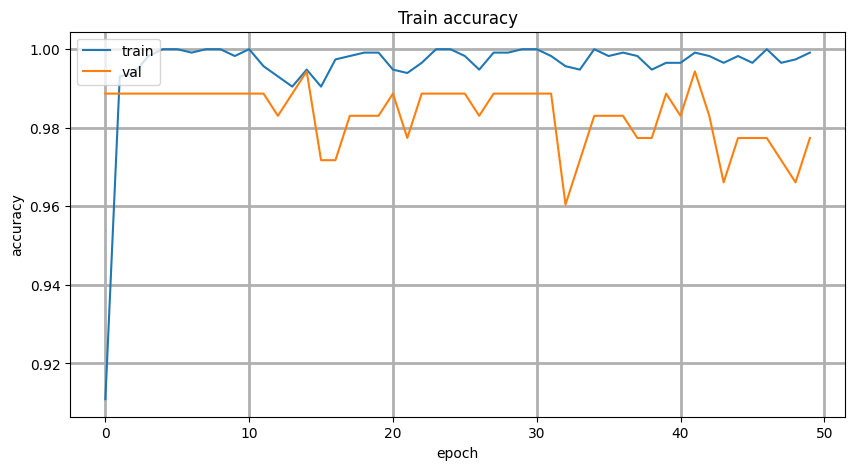

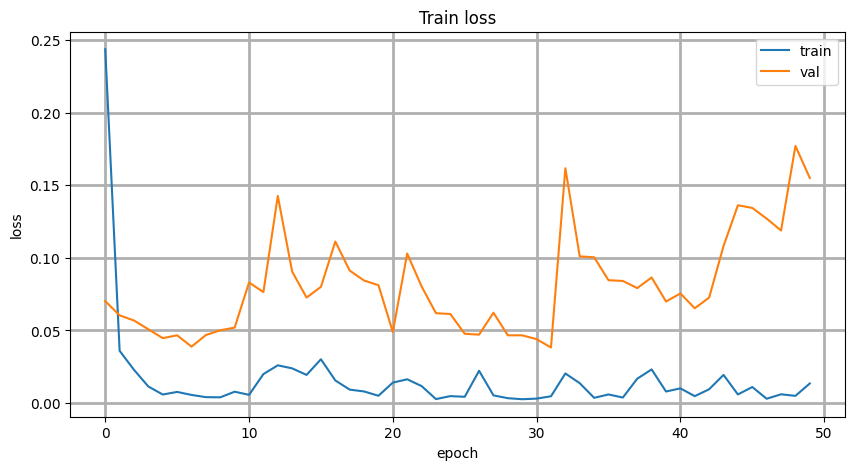

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history8.history['acc'])
plt.plot(history8.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - acc: 0.9837 - loss: 0.0645


[0.0684330016374588, 0.9830508232116699]

In [ ]:
#save model8
model8.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_5.h5')

###Round 3

In [ ]:
# Classifier head
# Add Dense layers
dense_512 = tf.keras.layers.Dense(512, activation='relu', name='dense_512')(vit_features[:, 0, :])
bn_512 = tf.keras.layers.BatchNormalization(name='bn_512')(dense_512)
dropout5 = tf.keras.layers.Dropout(0.25)(bn_512)

dense_256 = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(dropout5)
bn_256 = tf.keras.layers.BatchNormalization(name='bn_256')(dense_256)
dropout6 = tf.keras.layers.Dropout(0.25)(bn_256)

cls_outputs_m8 = tf.keras.layers.Dense(2, activation='softmax', name='cls_outputs_m8')(dropout6)

# Construct the model
model8 = tf.keras.Model(inputs=[img_inputs], outputs=[cls_outputs_m8])
model8.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ img_inputs (InputLayer)              │ (None, 3, 224, 224)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 198, 768)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_2 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_512 (Dense)                    │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_512 (BatchNormalization)          │ (None, 512)                 │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_256 (BatchNormalization)          │ (None, 256)                 │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cls_outputs_m8 (Dense)               │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,642 (2.02 MB)

 Trainable params: 527,106 (2.01 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
model8.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Evaluate the model BEFORE finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 536ms/step - acc: 0.6980 - loss: 0.6584


[0.6553113460540771, 0.700564980506897]

In [ ]:
# Finetune (train) the model
ct_start = datetime.datetime.now()
history8 = model8.fit( x_train_vit, y_train_vit_encoded,
                      validation_data=(x_val_vit,y_val_vit_encoded),
                      batch_size=32, epochs=50 ) # adjust
ct_end = datetime.datetime.now()
print("runtime: ", ct_end - ct_start)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 239ms/step - acc: 0.8171 - loss: 0.4236 - val_acc: 0.9831 - val_loss: 0.0748
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9878 - loss: 0.0410 - val_acc: 0.9887 - val_loss: 0.0672
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 1.0000 - loss: 0.0134 - val_acc: 0.9887 - val_loss: 0.0452
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9982 - loss: 0.0159 - val_acc: 0.9887 - val_loss: 0.0411
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9935 - loss: 0.0203 - val_acc: 0.9887 - val_loss: 0.0665
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - acc: 0.9962 - loss: 0.0177 - val_acc: 0.9887 - val_loss: 0.0492
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - acc: 1.0000 - loss: 0.0057 - val_acc: 0.9887 - val_loss: 0.0627
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - acc: 0.9973 - loss: 0.0130 - val_acc: 0.9831 - val_loss: 0.0831
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - a

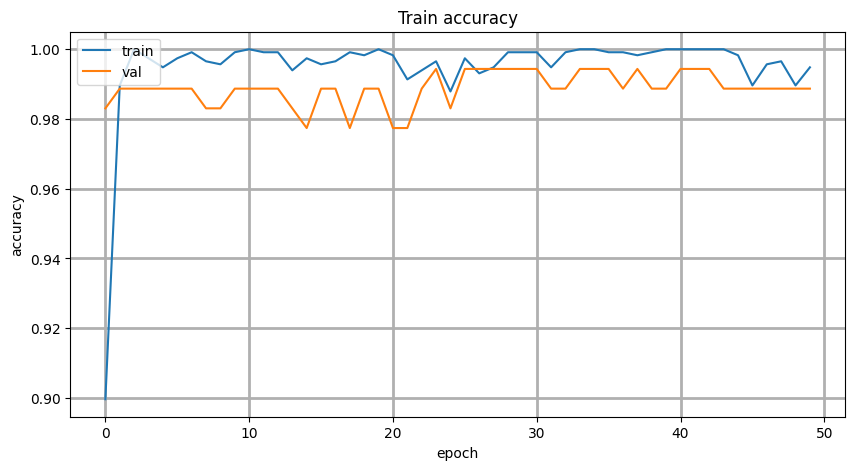

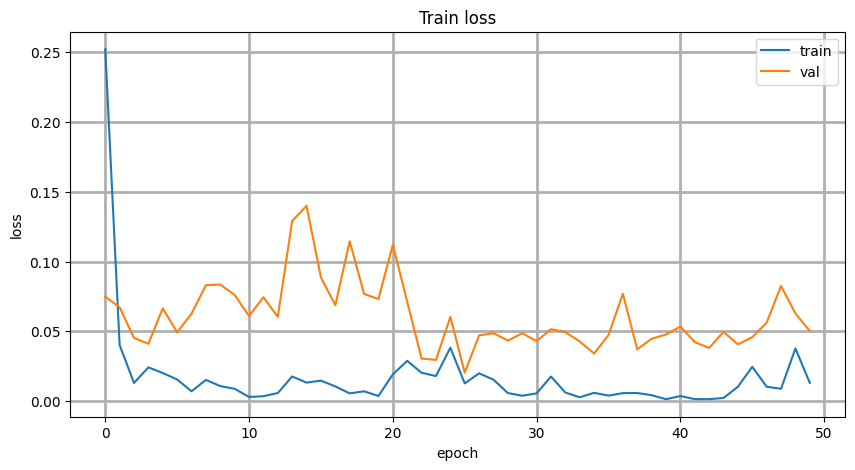

In [ ]:
# Summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(history8.history['acc'])
plt.plot(history8.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(axis='both',linewidth = 2)
plt.show()

# Summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(axis='both',linewidth = 2)
plt.show()

In [ ]:
# Evaluate the model AFTER finetuning
model8.evaluate(x_test_vit, y_test_vit_encoded)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - acc: 0.9741 - loss: 0.0361


[0.03723900392651558, 0.9774011373519897]

In [ ]:
#save model8
model8.save('/content/drive/MyDrive/DADS_Deep Learning/Final_Project/save_model/deit_step_5.h5')

-----